In [2]:
using CSV, DataFrames, Random, LinearAlgebra, Distances, Distributions, SpecialFunctions, Plots

#Necessary functions

function alpha_gt(x::Float64, y::Float64, omega::Float64, t::Float64)
    
        al=0
        if(abs(x-y)<t) 
             al=exp(-((x-y)^2)/(omega^2))
             #denom=(pi/2)*(erf(t/omega)-erf(-t/omega))
             #al/=denom
        end
        return al
    end
    
    function alpha_tri(x::Float64, y::Float64, slope::Float64, t::Float64)
        
        alpha=0.0
        
        if ( abs(x-y) < t) 
            
            alpha=1- (slope*abs(x-y))
            
        end
            
        return max(0,alpha)
        
    end
        
    
    function mc_gt(x::Vector{Float64},y::Vector{Float64},omega::Float64, t::Float64)
        
        res=0
        
        for i in 1:10^6
            
            x1=sample(x)
            y1=sample(y)
            
            res+=(mean(x)-x1)*alpha_gt(x1,y1,omega,t)
            
        end
        return res/(10^6)
        
    end
    
    function mc_tri(x::Vector{Float64},y::Vector{Float64},slope::Float64, t::Float64)
        
        res=0
        
        for i in 1:10^6
            
            x1=sample(x)
            y1=sample(y)
            
            res+=(mean(x)-x1)*alpha_tri(x1,y1,slope,t)
            
        end
        return res/(10^6)
        
    end

function mnnds(a::Vector{Float64})
    
    a=filter!(!isnan,a)
    if(length(a)>1)
        a=sort(a,rev=true)
        nnd=zeros(Float64,length(a))
        nnd[1]=a[2]-a[1]
        nnd[length(nnd)]=a[length(a)]-a[length(a)-1]
        for i in 2:((length(a)-1))
            nnd[i]=min((a[i-1]-a[i]),(a[i]-a[i+1]))
        end
        ranges=a[1]-a[end]
        mnnd=sum(nnd)/length(nnd)
        mmax=ranges/(length(a)-1)

        return mnnd/mmax
        
    else return 0.0
    end
        
end
        
    function qgprob(n::Int64)
    
        #All possible phenotypes
        pheno= collect(1:(2*n+1)) ./ (2*n+1)
        nt=length(pheno)
    
        G=zeros(Float64,n+1,n+1,n+1)
    
        for i in 0:n, j in 0:i, k in max(0,(i+j-n)):min(n,(i+j))
                    m=collect(0:min(j,k,i+j-k))
                    G[1+i,1+j,1+k]=sum(pdf.(Hypergeometric(i,n-i,j),m).*pdf.(Binomial.(i+j .- (2 .* m)),k .- m))
        end
    
        for k in 0:n
            G[:,:,1+k]=G[:,:,1+k]+transpose(G[:,:,1+k])
            for i1 in 0:n
                G[i1+1,i1+1,k+1] /= 2
            end
        end
    
        ind_haplR=zeros(Float64,2*n+1, 2*n+1)
    
        for k in 0:n
            for i in 0:n
                 ind_haplR[1+i,1+k] = G[1+i,1,1+k]
                for j in 0:n
                    ind_haplR[1+j+n,1+k]=G[1+n,1+j,1+k]
                end
            end
        end
    
        R=zeros(Float64,nt,nt,nt)
    
        for i in 0:(2*n), j in 0:(2*n), q in 0:(2*n)
             R[1+i,1+j,1+q]= sum(ind_haplR[1+i,1 .+ (0:q)] .*
                                 ind_haplR[1+j,1+q .- (0:q)])
        end
    
        return R
    end
    

    
    
    
    function single_sim(r,K,a1,A,R,Ng0,Npop)
        
            Np0=Ng0 .*Npop
            Ngen=deepcopy(Ng0)
            Np=deepcopy(Np0)
        
            dat=zeros(Float64,1000,nsp,nt)
            
            #Start the simulation
            for m in 1:1000
        
                #Determine the extinct species
                Np[findall(sum(Np,dims=2) .< 10),:] .= 0
                Ngen[findall(sum(Np,dims=2) .==0),:] .= 0
    
                if all(sum(Np,dims=2) ==0) 
                    break
                else
    
                    newgen=zeros(Float64,nsp,nt)
    
                    #Reproduction event
                    for i in findall(!iszero,sum(eachcol(Ngen)))
    
                        probs=Ngen[i,:]*Ngen[i,:]'
                    
                        newgen[i,:]=[sum(probs.*R[:,:,j]) for j in 1:nt]
                    
                        newgen[i,:] ./= sum(newgen[i,:])
                        
                    end
    
                    newp=newgen .* sum(Np,dims=2)
    
                    #Selection event
                
                    if size(A)[1]>1
    
                        for i in 1:size(newp)[1]

                            comps=[sum((a1*A[j,:]) .* newp[1:end .!=i,:]') + sum(A[j,:] .* newp[i,:]) for j in 1:nt]
                        
                            Np[i,:] += newp[i,:] .* r[i] .* (1 .-(comps ./K[i]))

                        end
                    
                    end
    
                    Np[findall(Np .<1)] .= 0
                    Ngen= Np ./ sum(Np,dims=2)
                    Ngen[isnan.(Ngen)].=0
                end
                
            dat[m,:,:]=Np
                
            end
        
        return dat
        
    end
    
 function single_sim1(time,r,K1,K2,a1,A,R,Ng0,Npop)
        
            nsp=size(Ng0)[1]
            nt=size(Ng0)[2]
            
            Np0=Ng0 .*Npop
            Ngen=deepcopy(Ng0)
            Np=deepcopy(Np0)
        
            dat=zeros(Float64,time+1,nsp,nt)
    
            dat[1,:,:]=Np
            
            #Start the simulation
            for m in 2:(time+1)
        
                #Determine the extinct species
                Np[findall(sum(Np,dims=2) .< 10),:] .= 0
                Ngen[findall(sum(Np,dims=2) .==0),:] .= 0
    
                if all(sum(Np,dims=2) ==0) 
                    break
                else
    
                    newgen=zeros(Float64,nsp,nt)
    
                    #Reproduction event
                    for i in findall(!iszero,sum(eachcol(Ngen)))
    
                        probs=Ngen[i,:]*Ngen[i,:]'
                    
                        newgen[i,:]=[sum(probs.*R[:,:,x1]) for x1 in 1:nt]
                    
                        newgen[i,:] ./= sum(newgen[i,:])
                        
                    end
    
                    newgen .*= sum(Np,dims=2)
    
                    #Selection event
                
                    if size(A)[1]>1
    
                        for i1 in 1:size(newgen)[1]
                    
                            #Reduction in growth rate due to intraspecific competition (not trait-dependent!). The carrying capacity
                            #here is assumed to be the same for all species.

                            rdash=r[i1] * (1 -(sum(newgen[i1,:])/K2))
                        
                            #Impact of interspecific competition

                            comps=[(a1.*sum((A[x2,:]) .* newgen[1:end .!=i1,:]')) for x2 in 1:nt]
                        
                            Np[i1,:] = newgen[i1,:] + (newgen[i1,:] .* rdash .* (1 .-(comps ./K1)))
                        
                        end
                    
                    end
    
                    Np[findall(Np .<1)] .= 0
                    Ngen= Np ./ sum(Np,dims=2)
                    Ngen[isnan.(Ngen)].=0
                end
                
            dat[m,:,:]=Np
                
            end
        
        return dat
        
    end
    
    
#Blanket function to create trait and population trajectories
function getsum(time,r,K1,K2,a1,A,R,Ng0,Npop)
        
        res=single_sim1(time,r,K1,K2,a1,A,R,Ng0,Npop)
        
        tstep=size(res)[1]
        nsp=size(res)[2]
        nt=size(res)[3]
                
        geno=collect(range(-1.0,stop=1.0,length=nt))
        
        pops=zeros(Float64,tstep,nsp)
        trmeans=zeros(Float64,tstep,nsp)

        for i in 1:nsp

        pops[:,i]=[sum(res[x,i,:]) for x in 1:tstep]
        trmeans[:,i]=[sum(res[x,i,:] .* geno)/sum(res[x,i,:])  for x in 1:tstep]

        end

        return([pops,trmeans])
        
end
    

getsum (generic function with 1 method)

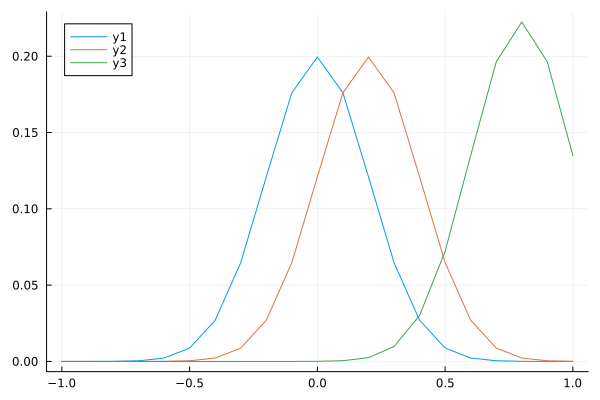

In [14]:
n=10
geno=collect(range(-1.0,stop=1.0,length=2*n+1))
nt=length(geno)

trmeans=[0.0,0.2,0.8]
Ns=zeros(Float64,length(trmeans),nt)

[Ns[i,:]=pdf.(truncated(Normal(trmeans[i],0.2),-1.0,1.0),geno) for i in 1:length(trmeans)]

Ns= Ns ./ sum(Ns,dims=2)

#Set up comp. kernel
omega=1.0
t=0.75

Ag=zeros(Float64,nt,nt)

for i1 in 1:nt, i2 in 1:nt
    Ag[i1,i2]=alpha_gt(geno[i1],geno[i2],omega,t)
end

#test plot of comp kernel
xs=collect(-1.0:0.05:1.0)
ys=[alpha_gt(xs[i],0.0,omega,t) for i in 1:length(xs)]

kernelp=plot(xs,ys,xlim=(-1.0,1.0))
    

#test plot of trait distributions
trplot=plot(geno,Ns[1,:])
for i in 2:length(trmeans)
    plot!(geno,Ns[i,:],col=i)
    #vline!(trmeans[i])
end
trplot    


In [21]:
Ns[1,:]

21-element Vector{Float64}:
 7.433598421472065e-7
 7.991871464924255e-6
 6.691512051410026e-5
 0.0004363413972875395
 0.002215924458694796
 0.00876415124633416
 0.02699548633542444
 0.06475880521867608
 0.12098537605793229
 0.17603268345864598
 0.19947116295036696
 0.17603268345864598
 0.12098537605793229
 0.06475880521867608
 0.02699548633542444
 0.00876415124633416
 0.002215924458694796
 0.0004363413972875395
 6.691512051410026e-5
 7.991871464924255e-6
 7.433598421472065e-7

In [15]:
#Calculate the effect of competition on mean traits of each species
Ns_new=deepcopy(Ns)

#for i1 in 1:length(trmeans)
i=1   
N1=Ag[i,:] .* (sum(Ns[1:end .!=i,:],dims=1))'

    
    


21×1 Matrix{Float64}:
 3.037968136495781e-9
 5.331346449622369e-8
 7.142184867655922e-7
 7.304084071878279e-6
 5.7021803528989604e-5
 0.0003398260869419464
 0.001546013815538493
 0.005369233759228706
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [2]:
n=10
geno=collect(range(-1.0,stop=1.0,length=2*n+1))
nt=length(geno)

#Set trait distributions for all the competing species
trmeans=[0.0,0.2,0.8]
Ns=zeros(Float64,length(trmeans),nt)

[Ns[i,:]=pdf.(truncated(Normal(trmeans[i],0.2),-1.0,1.0),geno) for i in 1:length(trmeans)]

Ns= Ns ./ sum(Ns,dims=2)

#Set up comp. kernel
omega=1.0
t=0.75

Ag=zeros(Float64,nt,nt)

for i1 in 1:nt, i2 in 1:nt
    Ag[i1,i2]=alpha_gt(geno[i1],geno[i2],omega,t)
end



#test plot of comp kernel
xs=collect(-1.0:0.05:1.0)
ys=[alpha_gt(xs[i],0.0,omega,t) for i in 1:length(xs)]

kernelp=plot(xs,ys,xlim=(-1.0,1.0))
    
#test plot of trait distributions
trplot=plot(geno,Ns[1,:])
for i in 2:length(trmeans)
    plot!(geno,Ns[i,:],col=i)
    plot!(trmeans[i],seriestype="vline",;label=trmeans[i])
end
trplot    

#Calculate the effect of competition on mean traits of each species
Ns_new=deepcopy(Ns)

#for i1 in 1:length(trmeans)
    
    
    




LoadError: Cannot convert Float64 to series data for plotting

In [ ]:
for i1 in 1:length(trmeans)
    N1=Ag[i1,:] .* (sum(Ns[1:end .!=i1,:],dims=1))'
    


In [ ]:
function comp_demo(trdist::Vector{String},
                    kernel::Vector{String}
                    trmean::Vector{Float64},
                    trvar::Float64,
                    n::Int64,
                    omega::Float64,
                    slope::Float64,
                    t::Float64                    
                    )
    
    geno=collect(range(-1.0,stop=1.0,length=2*n+1))
    nt=length(geno)
    
    #Kernel parameters(fixed)
    omega=1.0
    slope=0.75
    t=0.5
    a1=0.1
    
    if trdist=="uniform"
        
        

In [ ]:
#Plot beta functions for different parameter combinations

n=10
geno= collect(range(-1.0,stop=1.0,length=2*n+1))
nt=length(geno)

#Parameters related to the competition kernels
    omega=1.5
    slope=0.5
    t=0.5
    a1=0.1

#Set the mean trait value for species no. 2
means=collect(-1.8:0.005:1.8)

#Pre-calculate coefficients of competition between pairs of phenotypes

A0g=zeros(Float64,nt,nt)
A0t=zeros(Float64,nt,nt)


for i1 in 1:nt, i2 in 1:nt
    
    A0g[i1,i2]=alpha_gt(geno[i1],geno[i2],omega,t)
    A0t[i1,i2]=alpha_tri(geno[i1],geno[i2],slope,t)
    
end

A1t=0.5 .* A0t

A1g= 0.5 .*A0g


##############################

#Assign probabilities for all phenotypes of spp. 1 and assume that mean trait value for species 1 is 0.0.

N1=pdf.(Uniform(-0.2,0.2),geno)
    
N1=N1 ./ sum(N1)

betas1=zeros(Float64,length(means))

for i in 1:length(means)
    
    #Create a trait distribution around the mean trait value for spp. 2

    N2=pdf.(Uniform(means[i]-0.2,means[i]+0.2),geno)

    N2= N2 ./ sum(N2)

    N1n= map(x-> sum(A1g[x,:].*N2),1:length(N1))
    
    newfreq=(1 .- N1n).*N1

    newfreq=newfreq ./ sum(newfreq)
        
    betas1[i]=sum(newfreq .* geno)
    
end


p1=plot(means,betas1,title="Uniform distribution + Gaussian Kernel",titlefont=font(9),ylim=(-0.05,0.05))


########################################################################################################
#Case 2: Gaussian distributed traits + truncated gaussian comp. kernel
########################################################################################################

#Assign probabilities for all phenotypes of spp. 1 and assume that mean trait value for species 1 is 0.0.

N1=pdf.(truncated(Normal(0.0,0.2),-1.0,1.0),geno)
    
N1=N1 ./ sum(N1)

betas2=zeros(Float64,length(means))

for i in 1:length(means)
    
    #Create a trait distribution around the mean trait value for spp. 2

    N2=pdf.(truncated(Normal(means[i],0.2),-1.0,1.0),geno)

    N2= N2 ./ sum(N2)

    N1n= map(x-> sum(A1g[x,:].*N2),1:length(N1))
    
    newfreq=(1 .- N1n).*N1

    newfreq=newfreq ./ sum(newfreq)
        
    betas2[i]=sum(newfreq .* geno)
    
end

p2=plot(means,betas2,title="Gaussian distribution + Gaussian Kernel",titlefont=font(9),ylim=(-0.05,0.05))

########################################################################################################
#Case 3: Gaussian distributed traits + Triangular comp. kernel
########################################################################################################

#Assign probabilities for all phenotypes of spp. 1 and assume that mean trait value for species 1 is 0.0.

N1=pdf.(truncated(Normal(0.0,0.2),-1.0,1.0),geno)
    
N1=N1 ./ sum(N1)

betas3=zeros(Float64,length(means))

for i in 1:length(means)
    
    #Create a trait distribution around the mean trait value for spp. 2

    N2=pdf.(truncated(Normal(means[i],0.2),-1.0,1.0),geno)

    N2= N2 ./ sum(N2)

    N1n= map(x-> sum(A1t[x,:].*N2),1:length(N1))
    
    newfreq=(1 .- N1n).*N1

    newfreq=newfreq ./ sum(newfreq)
        
    betas3[i]=sum(newfreq .* geno)
    
end

p3=plot(means,betas3,title="Gaussian distribution + Triangular Kernel",titlefont=font(9),ylim=(-0.05,0.05))

########################################################################################################
#Case 4: Uniformly distributed traits + Triangular comp. kernel
########################################################################################################

#Assign probabilities for all phenotypes of spp. 1 and assume that mean trait value for species 1 is 0.0.

N1=pdf.(Uniform(-0.2,0.2),geno)
    
N1=N1 ./ sum(N1)

betas4=zeros(Float64,length(means))

for i in 1:length(means)
    
    #Create a trait distribution around the mean trait value for spp. 2

    N2=pdf.(Uniform(means[i]-0.2,means[i]+0.2),geno)

    N2= N2 ./ sum(N2)

    N1n= map(x-> sum(A1t[x,:].*N2),1:length(N1))
    
    newfreq=(1 .- N1n).*N1

    newfreq=newfreq ./ sum(newfreq)
        
    betas4[i]=sum(newfreq .* geno)
    
end

p4=plot(means,betas4,title="Uniform distribution + Triangular Kernel",titlefont=font(9),ylim=(-0.05,0.05))

plot(p1,p4,p2,p3, layout = (2,2))

In [ ]:
   nsp=10
    n=5

    #traits range between -1 and 1.
    geno= collect(range(-1.0,stop=1.0,length=2*n+1))
    nt=length(geno)

    #Parameters related to the competition kernels
    omega=1.0
    slope=0.75
    t=1.0
    a1=0.1

    #Demographic parameters
    #intrinsic growth rate, assumed to be specific to each species,not the phenotypes.
    r=abs.(rand(Uniform(0.2,0.3),nsp))

    #Carrying capacity, however, is solely the function of the phenotype, not the species.
    #The total carrying capacity of the environment is held constant and split across different phenotypes.
    #As a simplifying first step, the carrying capacity is split evenly across all possible phenotypes.

    #K=20000 ./ (nt .* ones(Int64,nt))
    K1=15000
    K2=1500
    #Pre-calculate coefficients of competition between pairs of phenotypes

    Ag=zeros(Float64,nt,nt)
    At=zeros(Float64,nt,nt)

    for i1 in 1:nt, i2 in 1:nt

        Ag[i1,i2]=alpha_gt(geno[i1],geno[i2],omega,t)
        At[i1,i2]=alpha_tri(geno[i1],geno[i2],slope,t)
    end


    #Precalculate R, the outcomes of mating between each of pair of phenotypes
    R=qgprob(n)

    #Starting populations

    rands=rand(Uniform(-0.6,0.6),nsp)

    N_uni=zeros(Float64,nsp,nt)

    [N_uni[i,:]=pdf.(Uniform(rands[i]-0.4,rands[i]+0.4),geno) for i in 1:nsp]

    N_uni=N_uni ./ sum(N_uni,dims=2)

    N_gau=zeros(Float64,nsp,nt)

    [N_gau[i,:]=pdf.(truncated(Normal(rands[i],0.2),-1.0,1.0),geno) for i in 1:nsp]
    N_gau=N_gau ./ sum(N_gau,dims=2);


########################################################################################################
#Case 1: Uniformly distributed traits + truncated gaussian comp. kernel
########################################################################################################

#res=single_sim1(5000,r,2000.0,2000.0,0.1,Ag,R,N_uni,1000.0)

res1=getsum(5000,r,100000.0,200000.0,0.25,Ag,R,N_uni,1000.0)

pops=res1[1]

trdat=res1[2]

In [ ]:
#Long term simulations: Test the effect of no. of loci

#Sample initial conditions

  nsp=10

 #Starting population means

    rands=rand(Uniform(-0.6,0.6),nsp)
  
    #Parameters related to the competition kernels
    omega=1.0
    slope=0.75
    t=0.5
    a1=0.5

    #Demographic parameters
    #intrinsic growth rate, assumed to be specific to each species,not the phenotypes.
    r=abs.(rand(Uniform(0.2,0.3),nsp))

    #Carrying capacity, however, is solely the function of the phenotype, not the species.
    #The total carrying capacity of the environment is held constant and split across different phenotypes.
    #As a simplifying first step, the carrying capacity is split evenly across all possible phenotypes.

    #K=20000 ./ (nt .* ones(Int64,nt))
    K1=5000
    K2=5000
########################################################################################################
#Case 1: n=5
########################################################################################################

n1=5
    #traits range between -1 and 1.
    geno1= collect(range(-1.0,stop=1.0,length=2*n1+1))
    nt1=length(geno1)
    #Pre-calculate coefficients of competition between pairs of phenotypes

    Ag1=zeros(Float64,nt1,nt1)

    for i1 in 1:nt1, i2 in 1:nt1

        Ag1[i1,i2]=alpha_gt(geno1[i1],geno1[i2],omega,t)
    end


    #Precalculate R, the outcomes of mating between each of pair of phenotypes
    R5=qgprob(n1)

    N_uni1=zeros(Float64,nsp,nt1)

    [N_uni1[i,:]=pdf.(Uniform(rands[i]-0.4,rands[i]+0.4),geno1) for i in 1:nsp]

    N_uni1=N_uni1 ./ sum(N_uni1,dims=2)

    res1=getsum(1000,r,K1,K2,a1,Ag1,R5,N_uni1,1000.0)
    pops1=res1[1]

    trdat1=res1[2]

    mndat1=[mnnds(trdat1[x,:]) for x in 1:size(trdat1)[1]]


    pplot1=plot(pops1[:,1],ylabel="Nt",title="5 Loci", legend = false)
    for i in 2:size(pops1)[2]
        plot!(pops1[:,i],col=i)
    end

    tplot1=plot(trdat1[:,1],ylabel="Mean trait",title="5 Loci", legend = false)
    for i in 2:size(trdat1)[2]
        plot!(trdat1[:,i],col=i)
    end
    plot!(mndat1,linestyle=:dash)



In [ ]:

########################################################################################################
#Case 2: n=10
########################################################################################################
n2=10
    #traits range between -1 and 1.
    geno2= collect(range(-1.0,stop=1.0,length=2*n2+1))
    nt2=length(geno2)
    #Pre-calculate coefficients of competition between pairs of phenotypes

    Ag2=zeros(Float64,nt2,nt2)

    for i1 in 1:nt2, i2 in 1:nt2

        Ag2[i1,i2]=alpha_gt(geno2[i1],geno2[i2],omega,t)
    end


    #Precalculate R, the outcomes of mating between each of pair of phenotypes
    R10=qgprob(n2)

    #Starting populations

    rands2=rand(Uniform(-0.6,0.6),nsp)

    N_uni2=zeros(Float64,nsp,nt2)

    [N_uni2[i,:]=pdf.(Uniform(rands2[i]-0.4,rands2[i]+0.4),geno2) for i in 1:nsp]

    N_uni2=N_uni2 ./ sum(N_uni2,dims=2)

res2=getsum(1000,r,K1,K2,a1,Ag2,R10,N_uni2,1000.0)
pops2=res2[1]

trdat2=res2[2]

mndat2=[mnnds(trdat2[x,:]) for x in 1:size(trdat2)[1]]


pplot2=plot(pops2[:,1],ylabel="Nt",title="10 Loci", legend = false)
for i in 2:size(pops2)[2]
    plot!(pops2[:,i],col=i)
end

tplot2=plot(trdat2[:,1],ylabel="Mean trait",title="10 Loci", legend = false)
for i in 2:size(trdat2)[2]
    plot!(trdat2[:,i],col=i)
end
plot!(mndat2,linestyle=:dash)
tplot2

In [ ]:

########################################################################################################
#Case 3: n=20
########################################################################################################
n3=20
    #traits range between -1 and 1.
    geno3= collect(range(-1.0,stop=1.0,length=2*n3+1))
    nt3=length(geno3)
    #Pre-calculate coefficients of competition between pairs of phenotypes

    Ag3=zeros(Float64,nt3,nt3)

    for i1 in 1:nt3, i2 in 1:nt3

        Ag3[i1,i2]=alpha_gt(geno3[i1],geno3[i2],omega,t)
    end


    #Precalculate R, the outcomes of mating between each of pair of phenotypes
    R20=qgprob(n3)

    #Starting populations

    rands3=rand(Uniform(-0.6,0.6),nsp)

    N_uni3=zeros(Float64,nsp,nt3)

    [N_uni3[i,:]=pdf.(Uniform(rands3[i]-0.4,rands3[i]+0.4),geno3) for i in 1:nsp]

    N_uni3=N_uni3 ./ sum(N_uni3,dims=2)

res3=getsum(1000,r,K1,K2,a1,Ag3,R20,N_uni3,1000.0)
pops3=res3[1]

trdat3=res3[2]

pplot3=plot(pops3[:,1],ylabel="Nt",title="20 Loci", legend = false)
for i in 2:size(pops3)[2]
    plot!(pops3[:,i],col=i)
end

tplot3=plot(trdat3[:,1],ylabel="Mean trait",title="20 Loci", legend = false)
for i in 2:size(trdat3)[2]
    plot!(trdat3[:,i],col=i)
end


pplot=plot(pplot1,pplot2,pplot3,layout=(2,2))
tplot=plot(tplot1,tplot2,tplot3,layout=(2,2))



In [ ]:
#Test the effect of no. of loci

nloci=[3,4,5,7,10,15,20,25,50]
nsp=10

plot_tr=[]
plot_pop=[]


for loci in nloci
    
    #Sample initial conditions

  n=loci

    #traits range between -1 and 1.
    geno= collect(range(-1.0,stop=1.0,length=2*n+1))
    nt=length(geno)

    #Parameters related to the competition kernels
    omega=1.0
    slope=0.75
    t=1.0
    a1=0.1

    #Demographic parameters
    #intrinsic growth rate, assumed to be specific to each species,not the phenotypes.
    r=abs.(rand(Uniform(0.2,0.3),nsp))

    #Carrying capacity, however, is solely the function of the phenotype, not the species.
    #The total carrying capacity of the environment is held constant and split across different phenotypes.
    #As a simplifying first step, the carrying capacity is split evenly across all possible phenotypes.

    #K=20000 ./ (nt .* ones(Int64,nt))
    #K1=15000
    #K2=1500
    #Pre-calculate coefficients of competition between pairs of phenotypes

    Ag=zeros(Float64,nt,nt)
    #At=zeros(Float64,nt,nt)

    for i1 in 1:nt, i2 in 1:nt

        Ag[i1,i2]=alpha_gt(geno[i1],geno[i2],omega,t)
        #At[i1,i2]=alpha_tri(geno[i1],geno[i2],slope,t)
    end
    
    #Precalculate R, the outcomes of mating between each of pair of phenotypes
    R=qgprob(n)

    #Starting populations

    rands=rand(Uniform(-0.6,0.6),nsp)

    #N_uni=zeros(Float64,nsp,nt)

    #[N_uni[i,:]=pdf.(Uniform(rands[i]-0.4,rands[i]+0.4),geno) for i in 1:nsp]

    #N_uni=N_uni ./ sum(N_uni,dims=2)

    N_gau=zeros(Float64,nsp,nt)

    [N_gau[i,:]=pdf.(truncated(Normal(rands[i],0.2),-1.0,1.0),geno) for i in 1:nsp]
    N_gau=N_gau ./ sum(N_gau,dims=2);
    
    res=getsum(2000,r,15000.0,2000.0,0.5,Ag,R,N_gau,1000.0)
    
    pplot1=plot(pops[:,1],ylabel="Nt",title=string("No. of loci:",n), legend = false)
    for i in 2:size(pops)[2]
        plot!(pops[:,i],col=i)
    end

    tplot1=plot(trdat[:,1],ylabel="Mean trait",title=string("No. of loci:",n), legend = false)
    for i in 2:size(trdat)[2]
        plot!(trdat[:,i],col=i)
    end
    
    push!(plot_tr,tplot1)
    push!(plot_pop,pplot1)

end

plot(plot_tr...)

In [ ]:
println(1:5...)

In [ ]:
plot(plot_pop...)

In [ ]:
anim=@animate for i ∈ 1:size(res)[1]
    
    plot(geno,res[i,1,:])
    for j in 2:nsp
        plot!(geno,res[i,j,:])
    end
end

gif(anim,fps=5)

In [ ]:
########################################################################################################
#Case 1: Uniformly distributed traits + truncated gaussian comp. kernel
########################################################################################################




In [ ]:
#plot kernels

xs=-2:0.1:2

ygt=[alpha_gt(0.0,x,omega,t) for x in xs]

ytri=[alpha_tri(0.0,x,slope,t) for x in xs]

p1=plot(xs,ygt)
plot!(xs,ytri)

#Plot initial trait distributions

p2=plot(geno,Np[1,:])

for i in 2:nsp
    
    plot!(geno,Np[i,:])
    
end

plot(p1,p2) 

In [ ]:
########################################################################################################
#Case 1: Uniformly distributed traits + truncated gaussian comp. kernel
########################################################################################################

n=15
geno= collect(range(-1.0,stop=1.0,length=2*n+1))
nt=length(geno)

#Parameters related to the competition kernels
omega=1.0
slope=0.63
t=1.0
a1=0.5

#Set the mean trait value for species no. 2
means=collect(-1.8:0.005:1.8)

#Pre-calculate coefficients of competition between pairs of phenotypes

A0g=zeros(Float64,nt,nt)
A0t=zeros(Float64,nt,nt)


for i1 in 1:nt, i2 in 1:nt
    
    A0g[i1,i2]=alpha_gt(geno[i1],geno[i2],omega,t)
    A0t[i1,i2]=alpha_tri(geno[i1],geno[i2],slope,t)
    
end

A1t=0.5 .* A0t

A1g= 0.5 .*A0g

#Assign probabilities for all phenotypes of spp. 1 and assume that mean trait value for species 1 is 0.0.

N1=pdf.(Uniform(-0.2,0.2),geno)
    
N1=N1 ./ sum(N1)

betas1=zeros(Float64,length(means))

for i in 1:length(means)
    
    #Create a trait distribution around the mean trait value for spp. 2

    N2=pdf.(Uniform(means[i]-0.2,means[i]+0.2),geno)

    N2= N2 ./ sum(N2)

    N1n= map(x-> sum(A1g[x,:].*N2),1:length(N1))
    
    newfreq=(1 .- N1n).*N1

    newfreq=newfreq ./ sum(newfreq)
        
    betas1[i]=sum(newfreq .* geno)
    
end


p1=plot(means,betas1,title="Uniform distribution + Gaussian Kernel",titlefont=font(9))


########################################################################################################
#Case 2: Gaussian distributed traits + truncated gaussian comp. kernel
########################################################################################################

#Assign probabilities for all phenotypes of spp. 1 and assume that mean trait value for species 1 is 0.0.

N1=pdf.(truncated(Normal(0.0,0.2),-1.0,1.0),geno)
    
N1=N1 ./ sum(N1)

betas2=zeros(Float64,length(means))

for i in 1:length(means)
    
    #Create a trait distribution around the mean trait value for spp. 2

    N2=pdf.(truncated(Normal(means[i],0.2),-1.0,1.0),geno)

    N2= N2 ./ sum(N2)

    N1n= map(x-> sum(A1g[x,:].*N2),1:length(N1))
    
    newfreq=(1 .- N1n).*N1

    newfreq=newfreq ./ sum(newfreq)
        
    betas2[i]=sum(newfreq .* geno)
    
end

p2=plot(means,betas2,title="Gaussian distribution + Gaussian Kernel",titlefont=font(9))

########################################################################################################
#Case 3: Gaussian distributed traits + Triangular comp. kernel
########################################################################################################

#Assign probabilities for all phenotypes of spp. 1 and assume that mean trait value for species 1 is 0.0.

N1=pdf.(truncated(Normal(0.0,0.2),-1.0,1.0),geno)
    
N1=N1 ./ sum(N1)

betas3=zeros(Float64,length(means))

for i in 1:length(means)
    
    #Create a trait distribution around the mean trait value for spp. 2

    N2=pdf.(truncated(Normal(means[i],0.2),-1.0,1.0),geno)

    N2= N2 ./ sum(N2)

    N1n= map(x-> sum(A1t[x,:].*N2),1:length(N1))
    
    newfreq=(1 .- N1n).*N1

    newfreq=newfreq ./ sum(newfreq)
        
    betas3[i]=sum(newfreq .* geno)
    
end

p3=plot(means,betas3,title="Gaussian distribution + Triangular Kernel",titlefont=font(9))

########################################################################################################
#Case 4: Uniformly distributed traits + Triangular comp. kernel
########################################################################################################

#Assign probabilities for all phenotypes of spp. 1 and assume that mean trait value for species 1 is 0.0.

N1=pdf.(Uniform(-0.2,0.2),geno)
    
N1=N1 ./ sum(N1)

betas4=zeros(Float64,length(means))

for i in 1:length(means)
    
    #Create a trait distribution around the mean trait value for spp. 2

    N2=pdf.(Uniform(means[i]-0.2,means[i]+0.2),geno)

    N2= N2 ./ sum(N2)

    N1n= map(x-> sum(A1t[x,:].*N2),1:length(N1))
    
    newfreq=(1 .- N1n).*N1

    newfreq=newfreq ./ sum(newfreq)
        
    betas4[i]=sum(newfreq .* geno)
    
end

p4=plot(means,betas4,title="Uniform distribution + Triangular Kernel",titlefont=font(9))

plot(p1,p4,p2,p3, layout = (2,2))

In [ ]:
#Run the long term simulations with different parameter combinations

  nsp=20
  n=10

    #traits range between -1 and 1.
    geno= collect(range(-1.0,stop=1.0,length=2*n+1))
    nt=length(geno)

    #Parameters related to the competition kernels
    omega=1.0
    slope=1.0
    t=1.0
    a1=0.15
    r=abs.(rand(Uniform(1.0,1.1),nsp))

    #Pre-calculate coefficients of competition between pairs of phenotypes

    A0g=zeros(Float64,nt,nt)
    A0t=zeros(Float64,nt,nt)

    for i1 in 1:nt, i2 in 1:nt

        A0g[i1,i2]=alpha_gt(geno[i1],geno[i2],omega,t)
        A0t[i1,i2]=alpha_tri(geno[i1],geno[i2],slope,t)
    end

    A1t=a1 .* A0t

    A1g= a1 .*A0g

    #Precalculate R, the outcomes of mating between each of pair of phenotypes
    R=qgprob(n)

    #Starting populations

    rands=rand(Uniform(-0.8,0.8),nsp)

    N_uni=zeros(Float64,nsp,nt)

    [N_uni[i,:]=pdf.(Uniform(rands[i]-0.2,rands[i]+0.2),geno) for i in 1:nsp]

    N_uni=N_uni ./ sum(N_uni,dims=2)

    N_gau=zeros(Float64,nsp,nt)

    [N_gau[i,:]=pdf.(truncated(Normal(rands[i],0.2),-1.0,1.0),geno) for i in 1:nsp]
    N_gau=N_gau ./ sum(N_gau,dims=2)



    ########################################################################################################
    #Case 1: Uniformly distributed traits + truncated gaussian comp. kernel
    ########################################################################################################
    Ng0=N_uni

    A1=A1g ./10000

    A0=A0g ./10000

    #single_sim(r,A1,A0,R, Ng0, Npop)

    result=single_sim1(r,nsp,A1,A0,R,Ng0,1000)

In [ ]:
#Run the long term simulations with different parameter combinations

  nsp=20
  n=10

    #traits range between -1 and 1.
    geno= collect(range(-1.0,stop=1.0,length=2*n+1))
    nt=length(geno)

    #Parameters related to the competition kernels
    omega=1.0
    slope=1.0
    t=1.0
    a1=0.15
    r=abs.(rand(Uniform(1.0,1.1),nsp))

    #Pre-calculate coefficients of competition between pairs of phenotypes

    A0g=zeros(Float64,nt,nt)
    A0t=zeros(Float64,nt,nt)

    for i1 in 1:nt, i2 in 1:nt

        A0g[i1,i2]=alpha_gt(geno[i1],geno[i2],omega,t)
        A0t[i1,i2]=alpha_tri(geno[i1],geno[i2],slope,t)
    end

    A1t=a1 .* A0t

    A1g= a1 .*A0g

    #Precalculate R, the outcomes of mating between each of pair of phenotypes
    R=qgprob(n)

    #Starting populations

    rands=rand(Uniform(-0.8,0.8),nsp)

    N_uni=zeros(Float64,nsp,nt)

    [N_uni[i,:]=pdf.(Uniform(rands[i]-0.2,rands[i]+0.2),geno) for i in 1:nsp]

    N_uni=N_uni ./ sum(N_uni,dims=2)

    N_gau=zeros(Float64,nsp,nt)

    [N_gau[i,:]=pdf.(truncated(Normal(rands[i],0.2),-1.0,1.0),geno) for i in 1:nsp]
    N_gau=N_gau ./ sum(N_gau,dims=2)



    ########################################################################################################
    #Case 1: Uniformly distributed traits + truncated gaussian comp. kernel
    ########################################################################################################
    Ng0=N_uni

    A1=A1g ./10000

    A0=A0g ./10000

    #single_sim(r,A1,A0,R, Ng0, Npop)

    result=single_sim(r,nsp,A1,A0,R,Ng0,1000)

    trmeans=zeros(Float64,1000,nsp)

    for i in 1:1000

        res=result[i,:,:]
        res=res ./ sum(res,dims=2)
        #res[isnan.(res)].=0

        trmeans[i,:]=sum(eachcol(geno' .* res))

    end

    p21=plot(trmeans[:,1],legend=false,xlabel="Timesteps",ylabel="Mean trait value",
                title="Uniform distribution + Gaussian Kernel",titlefont=font(9))

    [plot!(trmeans[:,i]) for i in 2:nsp]



    ########################################################################################################
    #Case 2:  Gaussian distributed traits + truncated gaussian comp. kernel
    ########################################################################################################
    Ng0=N_gau

    A1=A1g ./10000

    A0=A0g ./10000

    result=single_sim(r,nsp,A1,A0,R,Ng0,1000)

    trmeans=zeros(Float64,1000,nsp)

    for i in 1:1000

        res=result[i,:,:]
        res=res ./ sum(res,dims=2)
        #res[isnan.(res)].=0

        trmeans[i,:]=sum(eachcol(geno' .* res))

    end

    p22=plot(trmeans[:,1],legend=false,xlabel="Timesteps",ylabel="Mean trait value",
                title="Gaussian distribution + Gaussian Kernel",titlefont=font(9))

    [plot!(trmeans[:,i]) for i in 2:nsp]


    ########################################################################################################
    #Case 3:  Gaussian distributed traits + Triangular comp. kernel
    ########################################################################################################
    Ng0=N_gau

    A1=A1t ./10000

    A0=A0t ./10000

    result=single_sim(r,nsp,A1,A0,R,Ng0,1000)

    trmeans=zeros(Float64,1000,nsp)

    for i in 1:1000

        res=result[i,:,:]
        res=res ./ sum(res,dims=2)
        #res[isnan.(res)].=0

        trmeans[i,:]=sum(eachcol(geno' .* res))

    end

    p23=plot(trmeans[:,1],legend=false,xlabel="Timesteps",ylabel="Mean trait value",
                title="Gaussian distribution + Triangular Kernel",titlefont=font(9))

    [plot!(trmeans[:,i]) for i in 2:nsp]


    ########################################################################################################
    #Case 4:  Uniformly distributed traits + Triangular comp. kernel
    ########################################################################################################
    Ng0=N_uni

    A1=A1t ./10000

    A0=A0t ./10000

    result=single_sim(r,nsp,A1,A0,R,Ng0,1000)

    trmeans=zeros(Float64,1000,nsp)

    for i in 1:1000

        res=result[i,:,:]
        res=res ./ sum(res,dims=2)
        #res[isnan.(res)].=0

        trmeans[i,:]=sum(eachcol(geno' .* res))

    end

    p24=plot(trmeans[:,1],legend=false,xlabel="Timesteps",ylabel="Mean trait value",
                title="Uniform distribution + Triangular Kernel",titlefont=font(9))

    [plot!(trmeans[:,i]) for i in 2:nsp]



    plot(p21,p24,p22,p23, layout = (2,2))
                        

